In [ ]:
% DESCRIPTION: Demo code for running seqNMF on simulated and real data,
% including how to test significance of each factor on held-out data, and how to select lambda
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% originally written by Andrew Bahle and Emily Mackevicius 1/2018, edited by John D'Uva 10/2020

In [1]:
%% Generate some synthetic data
number_of_seqences = 3;
T = 3000; % length of data to generate
Nneurons = 10*ones(number_of_seqences,1); % number of neurons in each sequence
Dt = 3.*ones(number_of_seqences,1); % gap between each member of the sequence
NeuronNoise = 0.001; % probability of added noise in each bin
SeqNoiseTime = zeros(number_of_seqences,1); % Jitter parameter = 0%
SeqNoiseNeuron = 1.*ones(number_of_seqences,1); % Participation parameter = 100%
X = generate_data(T,Nneurons,Dt,NeuronNoise,SeqNoiseTime,SeqNoiseNeuron,0,0,0,0,0);

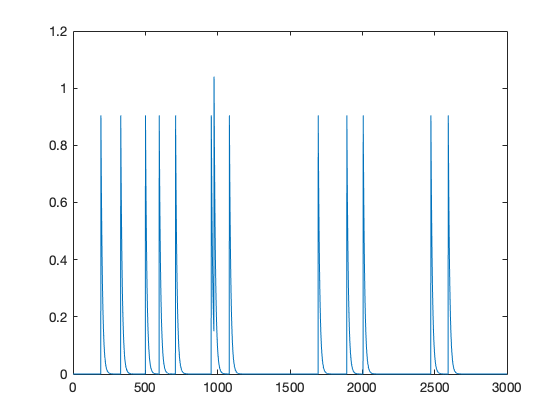

In [28]:
% Sanity check: Plot one of the time series 
plot(X(1,:))

Running seqNMF on simulated data (2 simulated sequences + noise)


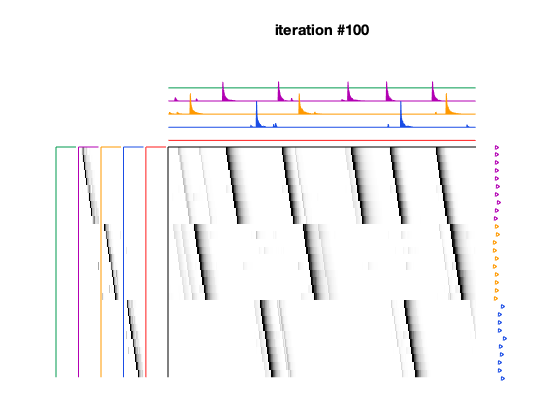

In [29]:
%% Fit with seqNMF:
% - X:      data matrix
% - K,L:    factorization parameters 
% - lambda: strength of regularization
K = 5;
L = 50;
lambda =.005;
shg; clf
display('Running seqNMF on simulated data (2 simulated sequences + noise)')
[W,H] = seqNMF(X,'K',K, 'L', L,'lambda', lambda);

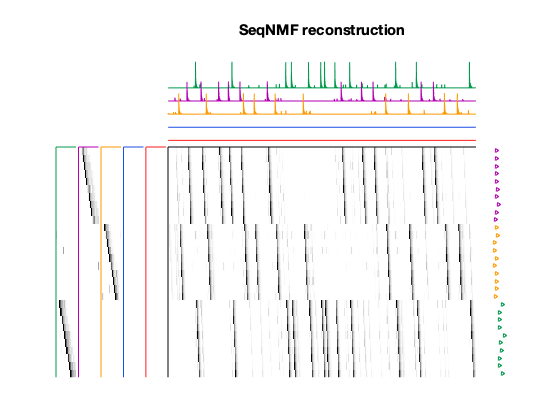

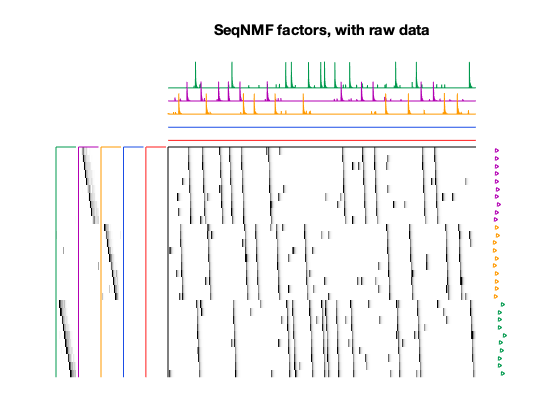

In [30]:
%% Look at factors
figure; SimpleWHPlot(W,H); title('SeqNMF reconstruction')
figure; SimpleWHPlot(W,H,X); title('SeqNMF factors, with raw data')

In [31]:
%% Procedure for choosing K
tic
Ws = {};
Hs = {};
numfits = 3; %number of fits to compare
for k = 1:10
    display(sprintf('running seqNMF with K = %i',k))
    for ii = 1:numfits
        [Ws{ii,k},Hs{ii,k}] = seqNMF(X,'K',k, 'L', L,'lambda', 0,'maxiter',30,'showplot',0); 
        % note that max iter set low (30iter) for speed in demo (not recommended in practice)
    end
    inds = nchoosek(1:numfits,2);
    for i = 1:size(inds,1) % consider using parfor for larger numfits
            Diss(i,k) = helper.DISSX(Hs{inds(i,1),k},Ws{inds(i,1),k},Hs{inds(i,2),k},Ws{inds(i,2),k});
    end
    
end

running seqNMF with K = 1
running seqNMF with K = 2
running seqNMF with K = 3
running seqNMF with K = 4
running seqNMF with K = 5
running seqNMF with K = 6
running seqNMF with K = 7
running seqNMF with K = 8
running seqNMF with K = 9
running seqNMF with K = 10


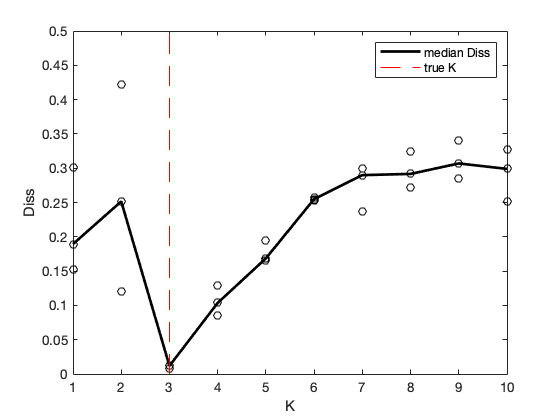

In [32]:
%% Plot Diss and choose K with the minimum average diss.
figure,
plot(1:10,Diss,'ko'), hold on
h1 = plot(1:10,median(Diss,1),'k-','linewidth',2);
h2 = plot([3,3],[0,0.5],'r--');
legend([h1 h2], {'median Diss','true K'})
xlabel('K')
ylabel('Diss')

In [33]:
%% Load example HVC calcium imaging data (from 6991FirstFewDaysForBatch)
clear all
display('Attempting to load MackeviciusData from seqNMF repository')
load MackeviciusData
display('loaded data')

Attempting to load MackeviciusData from seqNMF repository
loaded data


In [35]:
%% Break data into training set and test set
splitN = floor(size(NEURAL,2)*.75); 
splitS = floor(size(SONG,2)*.75); 
trainNEURAL = NEURAL(:,1:splitN); 
trainSONG = SONG(:,1:splitS); 
testNEURAL = NEURAL(:,(splitN+1):end); 
testSONG = SONG(:,(splitS+1):end); 

Running seqNMF on real neural data (from songbird HVC, recorded by Emily Mackevicius, Fee Lab)
Testing significance of factors on held-out data


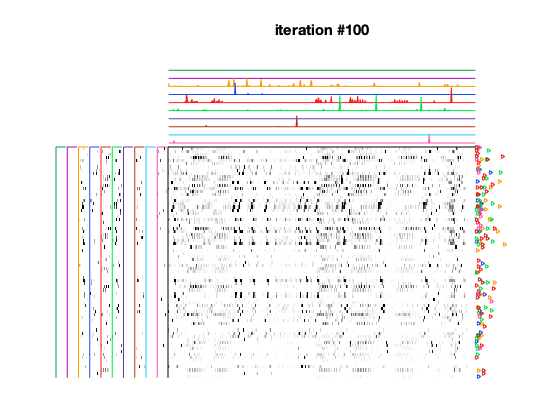

In [36]:
%% Plot one example factorization
rng(235); % fixed rng seed for reproduceability
X = trainNEURAL;
K = 10;
L = 2/3; % units of seconds
Lneural = ceil(L*VIDEOfs);  
Lsong = ceil(L*SONGfs);
shg
display('Running seqNMF on real neural data (from songbird HVC, recorded by Emily Mackevicius, Fee Lab)')
[W, H, ~,loadings,power]= seqNMF(X,'K',K,'L',Lneural,...
            'lambdaL1W', .1, 'lambda', .005, 'maxiter', 100, 'showPlot', 1,...
            'lambdaOrthoW', 0); 
p = .05; % desired p value for factors

display('Testing significance of factors on held-out data')
[pvals,is_significant] = test_significance(testNEURAL,W,p);

W = W(:,is_significant,:); 
H = H(is_significant,:); 

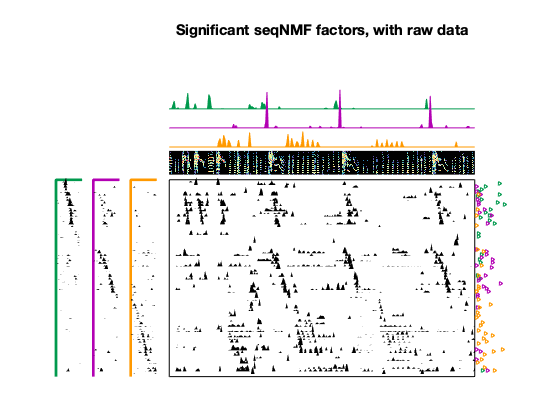

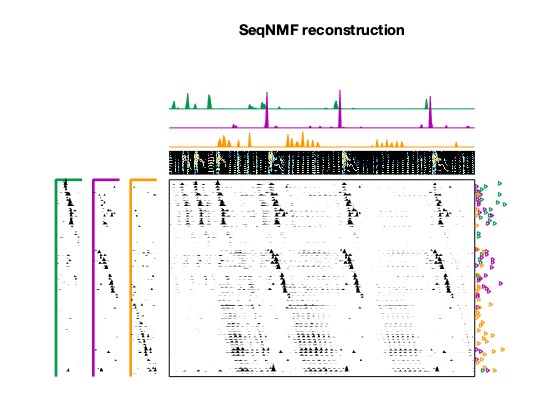

In [37]:
% Plot, sorting neurons by latency within each factor
[max_factor, L_sort, max_sort, hybrid] = helper.ClusterByFactor(W(:,:,:),1);
indSort = hybrid(:,3);
tstart = 180; % plot data starting at this timebin
figure; WHPlot(W(indSort,:,:),H(:,tstart:end), X(indSort,tstart:end), ...
    0,trainSONG(:,floor(tstart*SONGfs/VIDEOfs):end))
title('Significant seqNMF factors, with raw data')
figure; WHPlot(W(indSort,:,:),H(:,tstart:end), ...
    helper.reconstruct(W(indSort,:,:),H(:,tstart:end)),...
    0,trainSONG(:,floor(tstart*SONGfs/VIDEOfs):end))
title('SeqNMF reconstruction')

In [38]:
%% Procedure for choosing lambda
nLambdas = 20; % increase if you're patient
K = 10; 
X = trainNEURAL;
lambdas = sort([logspace(-1,-5,nLambdas)], 'ascend'); 
loadings = [];
regularization = []; 
cost = []; 
for li = 1:length(lambdas)
    [N,T] = size(X);
    [W, H, ~,loadings(li,:),power]= seqNMF(X,'K',K,'L',Lneural,...
        'lambdaL1W', .1, 'lambda', lambdas(li), 'maxiter', 100, 'showPlot', 0); 
    [cost(li),regularization(li),~] = helper.get_seqNMF_cost(X,W,H);
    display(['Testing lambda ' num2str(li) '/' num2str(length(lambdas))])
end

Testing lambda 1/20
Testing lambda 2/20
Testing lambda 3/20
Testing lambda 4/20
Testing lambda 5/20
Testing lambda 6/20
Testing lambda 7/20
Testing lambda 8/20
Testing lambda 9/20
Testing lambda 10/20
Testing lambda 11/20
Testing lambda 12/20
Testing lambda 13/20
Testing lambda 14/20
Testing lambda 15/20
Testing lambda 16/20
Testing lambda 17/20
Testing lambda 18/20
Testing lambda 19/20
Testing lambda 20/20


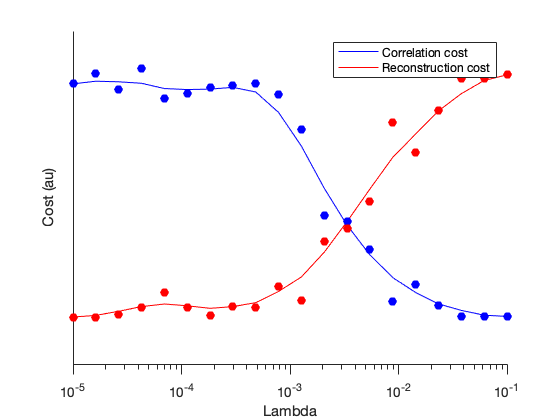

In [39]:
%% plot costs as a function of lambda
windowSize = 3; 
b = (1/windowSize)*ones(1,windowSize);
a = 1;
Rs = filtfilt(b,a,regularization); 
minRs = prctile(regularization,10); maxRs= prctile(regularization,90);
Rs = (Rs-minRs)/(maxRs-minRs); 
R = (regularization-minRs)/(maxRs-minRs); 
Cs = filtfilt(b,a,cost); 
minCs =  prctile(cost,10); maxCs =  prctile(cost,90); 
Cs = (Cs -minCs)/(maxCs-minCs); 
C = (cost -minCs)/(maxCs-minCs); 

clf; hold on
plot(lambdas,Rs, 'b')
plot(lambdas,Cs,'r')
scatter(lambdas, R, 'b', 'markerfacecolor', 'flat');
scatter(lambdas, C, 'r', 'markerfacecolor', 'flat');
xlabel('Lambda'); ylabel('Cost (au)')
set(legend('Correlation cost', 'Reconstruction cost'), 'Box', 'on')
set(gca, 'xscale', 'log', 'ytick', [], 'color', 'none')
set(gca,'color','none','tickdir','out','ticklength', [0.025, 0.025])

Running seqNMF multiple times for lambda=0.005
seqNMF run 1/20
seqNMF run 2/20
seqNMF run 3/20
seqNMF run 4/20
seqNMF run 5/20
seqNMF run 6/20
seqNMF run 7/20
seqNMF run 8/20
seqNMF run 9/20
seqNMF run 10/20
seqNMF run 11/20
seqNMF run 12/20
seqNMF run 13/20
seqNMF run 14/20
seqNMF run 15/20
seqNMF run 16/20
seqNMF run 17/20
seqNMF run 18/20
seqNMF run 19/20
seqNMF run 20/20


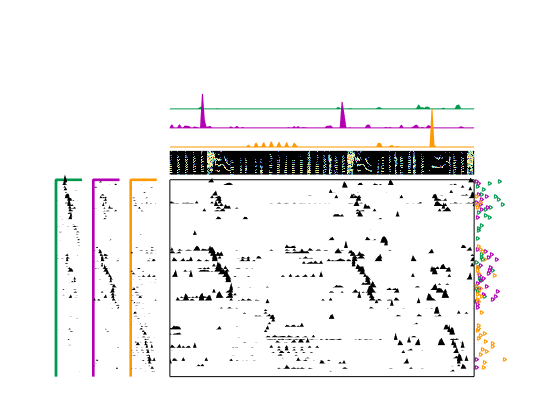

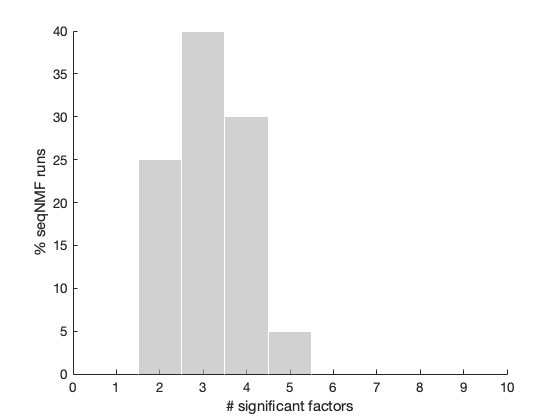

In [40]:
%% choose lambda=.005; run multiple times, see number of sig factors
loadings = [];
pvals = []; 
is_significant = []; 
X = trainNEURAL;
nIter = 20; % increase if patient
display('Running seqNMF multiple times for lambda=0.005')

for iteri = 1:nIter
    [W, H, ~,loadings(iteri,:),power]= seqNMF(X,'K',K,'L',Lneural,...
            'lambdaL1W', .1, 'lambda', .005, 'maxiter', 100, 'showPlot', 0); 
    p = .05;
    [pvals(iteri,:),is_significant(iteri,:)] = test_significance(testNEURAL,W,p);
    W = W(:,is_significant(iteri,:)==1,:); 
    H = H(is_significant(iteri,:)==1,:); 
    [max_factor, L_sort, max_sort, hybrid] = helper.ClusterByFactor(W(:,:,:),1);
    indSort = hybrid(:,3);
    tstart = 300; 
    clf; WHPlot(W(indSort,:,:),H(:,tstart:end), X(indSort,tstart:end), 0,trainSONG(:,floor(tstart*SONGfs/VIDEOfs):end))
    display(['seqNMF run ' num2str(iteri) '/' num2str(nIter)])
end
figure; hold on
h = histogram(sum(is_significant,2), 'edgecolor', 'w', 'facecolor', .7*[1 1 1]); 
h.BinCounts = h.BinCounts/sum(h.BinCounts)*100; 
xlim([0 10]); 
xlabel('# significant factors')
ylabel('% seqNMF runs')

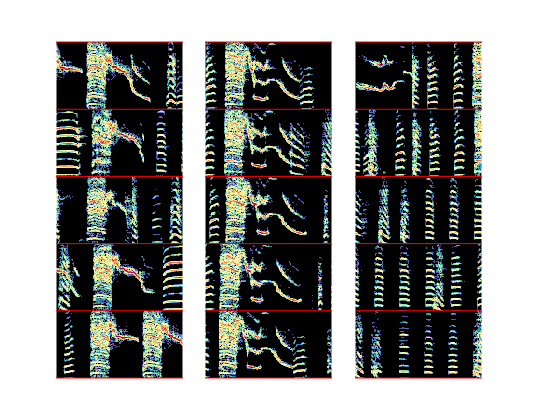

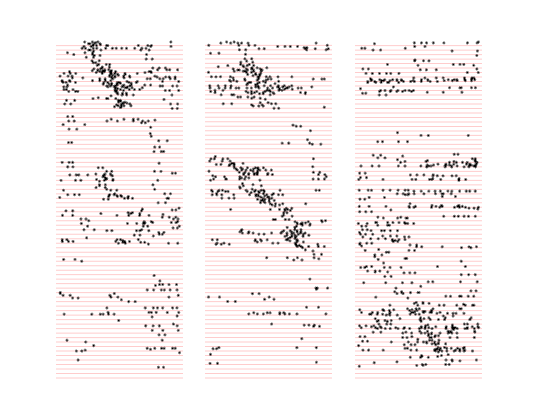

In [41]:
%% Plot factor-triggered song examples and rastors
addpath(genpath('misc_elm')); 
figure; HTriggeredSpec(H,trainSONG,VIDEOfs,SONGfs,Lsong); 
figure; HTriggeredRaster(H,trainNEURAL(indSort,:),Lneural);

Running seqNMF on simulated data, lambdaOrthoH -> events based


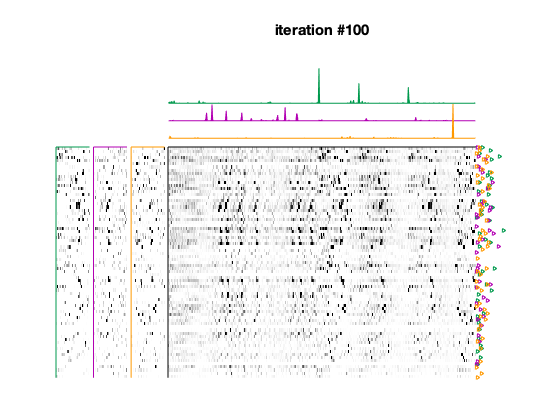

In [42]:
%% Example parts-based and events-based factorizations
K = 3;
L = 50;
lambda =0;
X = NEURAL; 

% run seqNMF with lambdaOrthoH -> events based
lambdaOrthoH = .1; % favor events-based (these can take any value, don't need to be zero and one)
lambdaOrthoW = 0;
display('Running seqNMF on simulated data, lambdaOrthoH -> events based')
figure; 
[W,H] = seqNMF(X,'K',K, 'L', L,'lambda', lambda, ...
    'lambdaOrthoH', lambdaOrthoH, 'lambdaOrthoW', lambdaOrthoW);

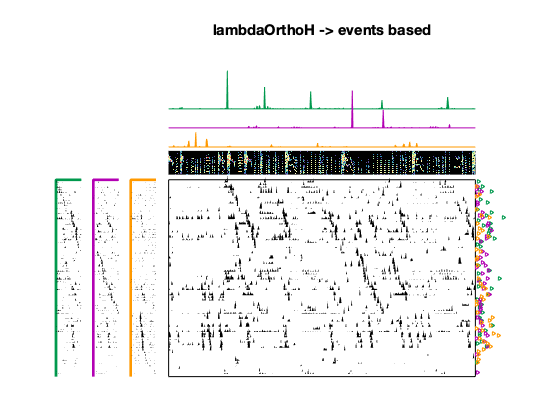

In [43]:
% sort neurons and plot
[max_factor, L_sort, max_sort, hybrid] = helper.ClusterByFactor(W(:,:,:),1);
indSort = hybrid(:,3);
tstart = 180; % plot data starting at this timebin
WHPlot(W(indSort,:,:),H(:,tstart:end), X(indSort,tstart:end), ...
    1,trainSONG(:,floor(tstart*SONGfs/VIDEOfs):end)); title('lambdaOrthoH -> events based')

Running seqNMF on simulated data, lambdaOrthoW -> parts based


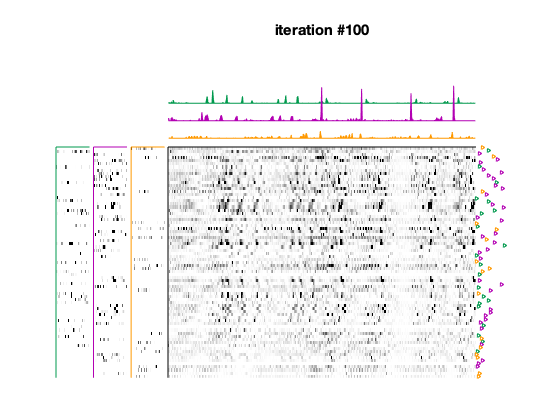

In [44]:
% run seqNMF with lambdaOrthoW -> parts based
figure; 
lambdaOrthoH = 0;  
lambdaOrthoW = 1; % favor parts-based (these can take any value, don't need to be zero and one)
display('Running seqNMF on simulated data, lambdaOrthoW -> parts based')
[W,H] = seqNMF(X,'K',K, 'L', L,'lambda', lambda, ...
    'lambdaOrthoH', lambdaOrthoH, 'lambdaOrthoW', lambdaOrthoW);

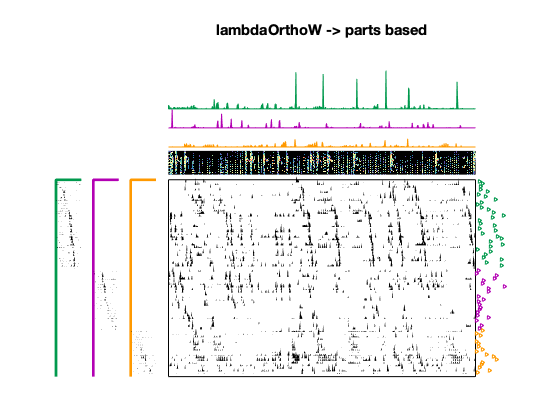

In [45]:
% sort neurons and plot
[max_factor, L_sort, max_sort, hybrid] = helper.ClusterByFactor(W(:,:,:),1);
indSort = hybrid(:,3);
WHPlot(W(indSort,:,:),H(:,:), X(indSort,:), ...
    1,trainSONG(:,:)); title('lambdaOrthoW -> parts based')

Cross validation on masked test set; Testing K = 8, rep 1
Cross validation on masked test set; Testing K = 8, rep 2
Cross validation on masked test set; Testing K = 8, rep 3
Cross validation on masked test set; Testing K = 8, rep 4
Cross validation on masked test set; Testing K = 8, rep 5
Cross validation on masked test set; Testing K = 7, rep 1
Cross validation on masked test set; Testing K = 7, rep 2
Cross validation on masked test set; Testing K = 7, rep 3
Cross validation on masked test set; Testing K = 7, rep 4
Cross validation on masked test set; Testing K = 7, rep 5
Cross validation on masked test set; Testing K = 6, rep 1
Cross validation on masked test set; Testing K = 6, rep 2
Cross validation on masked test set; Testing K = 6, rep 3
Cross validation on masked test set; Testing K = 6, rep 4
Cross validation on masked test set; Testing K = 6, rep 5
Cross validation on masked test set; Testing K = 5, rep 1
Cross validation on masked test set; Testing K = 5, rep 2
Cross validati

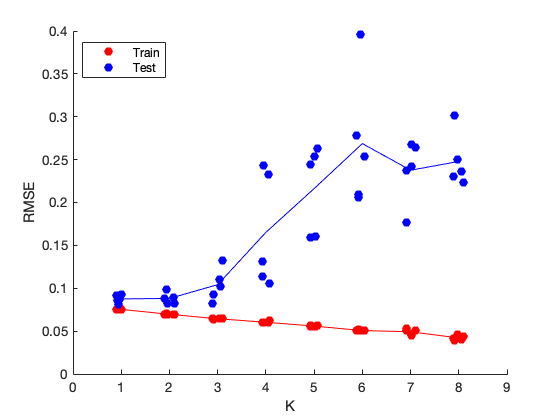

In [46]:
%% K sweep with masked cross-validation
nReps = 5; % increase if patient
Ks = 1:8; % increase if patient
L = 50;
X = NEURAL; 
[N,T] = size(NEURAL);
RmseTrain = zeros(length(Ks), nReps);
RmseTest = zeros(length(Ks), nReps);
figure
[~,Kplot] = meshgrid(1:nReps, Ks); 
Kplot = Kplot + rand(length(Ks), nReps)*.25-.125; 
parfor K = Ks
    for repi = 1:nReps
        display(['Cross validation on masked test set; Testing K = ' num2str(K) ', rep ' num2str(repi)])
        rng('shuffle')
        M = rand(N,T)>.05; % create masking matrix (0's are test set, not used for fit)
        [W,H] = seqNMF(X,'K', K, 'L', L,'lambda', 0,'showPlot', 0, 'M', M);
        Xhat = helper.reconstruct(W,H); 
        RmseTrain(K,repi) = sqrt(sum(M(:).*(X(:)-Xhat(:)).^2)./sum(M(:)));
        RmseTest(K,repi) = sqrt(sum((~M(:)).*(X(:)-Xhat(:)).^2)./sum(~M(:)));
    end
end

clf; scatter(Kplot(:), RmseTrain(:), 'r', 'markerfacecolor', 'flat'); 
hold on; 
scatter(Kplot(:), RmseTest(:), 'b', 'markerfacecolor', 'flat'); 
plot(mean(RmseTrain,2), 'r')
plot(mean(RmseTest,2), 'b')
xlabel('K'); ylabel('RMSE')
legend('Train', 'Test', 'location', 'northwest')
drawnow; shg

In [47]:
%% Calculate the sequenciness score
% WARNING TAKES A WHILE
load MackeviciusData

nRepsShuff = 15; 
nRepsColShuff = 15;  % just making an estimate, would need more to test sig
L = 20; % same as demo
K = 3; 

X = NEURAL; 
[N T] = size(X);

% do seqNMF 
tmp = [];

parfor iteri = 1:nIter
    rng('shuffle')
    [~, ~, ~,~,tmp(iteri)] = seqNMF(X, 'L', L, 'K', K, 'lambda', 0, 'showPlot',0);
end

PEx = max(tmp); 

% do seqNMF on shuffled data
PExShuff = [];
parfor repi = 1:nRepsShuff
    Xshuff = []; 
    for ni = 1:N
        timeshuff = randperm(T);
        Xshuff(ni,:) = X(ni, timeshuff); 
    end
    tmp = [];
    
    for iteri = 1:nIter
        rng('shuffle')
        [~, ~, ~,~,tmp(iteri)] = seqNMF(Xshuff, 'L', L, 'K', K, 'lambda', 0.0, 'showPlot',0);
    end
    PExShuff(repi) = max(tmp); 
end
        
% do seqNMF on col shuffled data
PExColShuff = [];
parfor repi = 1:nRepsColShuff
    Xshuff = X(:,[1:L (L + randperm(T-L))]); % don't shuffle to first L bins... these cannot be explained by seqNMF
    tmp = [];
    
    for iteri = 1:nIter
        rng('shuffle')
        [~, ~, ~,~,tmp(iteri)] = seqNMF(Xshuff, 'L', L, 'K', K, 'lambda', 0.0, 'showPlot',0);
    end    
    PExColShuff(repi) = max(tmp); 
end
NoiseFloor = median(PExShuff);
SyncFloor = median(PExColShuff);
PAS = (PEx-SyncFloor)./...
    (PEx-NoiseFloor)




PAS =

    0.7411

